In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importing sklearn module for data processing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Importing ML Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier
)

# Importing Classfication Metrics
from sklearn.metrics import (
    confusion_matrix,  classification_report, f1_score,
    precision_score, recall_score, accuracy_score, roc_curve, auc
)

# Importing SMOTE to balance the data
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

from copy import deepcopy

In [2]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["font.size"] = 16

##### **Notes for the functions below**
the "argument: object" and def "->" after function indicate annotation it won't affect the program at all.

In [440]:
def initialSetup(fl_path: str) -> pd.DataFrame:
    """This is the initial setup of the program
    
    User just have to provide the path to the dataset.
    The dataset should be in cv with ";" delimiter only.

    This function also check whether there are duplicates or not, then
    notify the user. If there are duplicates the function will remove
    duplicates until there are no longer duplicates.
    """

    # Read the data based on its filepath
    data = pd.read_csv(fl_path, delimiter=";")

    # Copy data for sanity check
    copy_data = data.copy()

    # Get duplicates by looping through the data until there is no duplicate
    n_duplicates = data.duplicated(keep=False).sum()
    while n_duplicates != 0:
        print(f"There are duplicates. Total duplicates: {n_duplicates}\n"
              +"Cleaning Duplicates....\n")
        data.drop_duplicates(keep="first", inplace=True)

        # Re-evaluate number of duplicates
        n_duplicates = data.duplicated(keep=False).sum()

    print("No duplicates in the data")

    # Running Sanity Check for data shape
    return data


In [439]:
def splittingData(data: pd.DataFrame, target: str) -> tuple:
    """Splitting Data Workflow
    
    This function is used to split the input and output data.
    Also to split the input-output data into train data and test data.
    The data would be distributed to the test data by 30% and 70% for
    the train data.

    We use margin error by 5% of the test size to give space for error
    when the data is splitted.
    """

    # defining test data proportion, margin error to make sure split the proportion
    # will not more or less than 5% of the defined proportion
    margin_error = 0.05
    test_size = 0.3

    # Get total variable from the entire data
    total_variables = len(data.columns)

    # Separate Independent Variable (Input) and target variable (output)
    # Common convention X is input, y is output
    y = data[target]
    X = data.drop(target, axis=1)

    # Sanity Check Input-Output
    # output data should only contain one column
    # input data should contain the rest of variable (total_variable-1)
    if (len(X.columns) == total_variables-1) \
        or (len(y.shape) == 1):
        print("Splitting Input-Output success")
    else:
        print("Splitting Input-Ouput failed")
        return None

    # Use the input and output data to split train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        stratify=y,
                                                        random_state=123)

    # Sanity Check for Train Split Data
    print("Sanity Check for Train and Test data shape...\n"
          +f"X_train data shape: {X_train.shape}\n"
          +f"X_test data shape: {X_test.shape}\n")
    
    # Create margin error of splitting result
    low_threshold = test_size-(test_size*margin_error)
    upper_threshold = test_size+(test_size*margin_error)

    # Define the test size ratio after data is splitted
    test_size_ratio = X_test.shape[0]/X.shape[0]

    # Sanity Check for Ratio
    print("Sanity Check for Train and Test data proportion....")
    if (test_size_ratio > low_threshold) \
        or (test_size_ratio < upper_threshold):
        print(f"Defined ratio: {test_size}\n"
              f"Ratio after splitting: {test_size_ratio}\n"
              +"Splitting proportion is similar")
    else:
        print(f"Defined ratio: {test_size}\n"
              f"Ratio after splitting: {test_size_ratio}\n"
              +"Splitting proportion is different")

    return X_train, X_test, y_train, y_test

In [441]:
def numericalImputer(data: pd.DataFrame, 
                     numerical_columns: list) -> tuple:
    """Numerical data preprocessing

    Preprocessing numerical data for train data with simple imputer.
    SimpleImputer object will be created to be used for the test data.
    """

    numerical_data = data[numerical_columns]

    # Creating imputer object and fitting the data
    imputer = SimpleImputer(missing_values=np.nan,
                            strategy="median")
    imputer.fit(numerical_data)

    # Transform imputed data and turn it into Pandas DataFrame
    imputed_data = imputer.transform(numerical_data)
    imputed_data = pd.DataFrame(data=imputed_data,
                                index=numerical_data.index,
                                columns=numerical_data.columns)

    return imputed_data, imputer

In [6]:
def categoricalImputer(data: pd.DataFrame, 
                       categorical_columns: list) -> tuple:
    """Categorical data preprocessing

    Preprocessing categorical data for train data with simpleImputer and ohe.
    simpleImputer and ohe encoder object will be created for the test data.
    """

    # Get Categorical Data
    categorical_data = data[categorical_columns]
    
    # 1. Handling missing value - SimpleImputer
    # Create imputer object and fitting the categorical data
    imputer = SimpleImputer(missing_values=np.nan,
                            strategy="constant",
                            fill_value = "Unknown")
    imputer.fit(categorical_data)
    
    imputed_data = imputer.transform(categorical_data)
    imputed_data = pd.DataFrame(data=imputed_data,
                                index=categorical_data.index,
                                columns=categorical_data.columns)

    # 2. Encode categorical ata
    # Create encoder object and fit the data
    ohe_encoder = OneHotEncoder(handle_unknown="ignore", drop="if_binary")
    ohe_encoder.fit(imputed_data)

    # Get encoder columns
    ohe_encoder_columns = ohe_encoder \
                          .get_feature_names_out(imputed_data.columns)

    # Tranfsorm categorical data
    data_encoded = ohe_encoder.transform(imputed_data).toarray()
    data_encoded = pd.DataFrame(data=data_encoded,
                                index=imputed_data.index,
                                columns=ohe_encoder_columns)

    return data_encoded, imputer, ohe_encoder, ohe_encoder_columns

In [7]:
def dataStandarization(data: pd.DataFrame) -> tuple:
    """Standardizing data
    
    Standardized train data and create scaler object for test data preprocess
    """

    # Create scaler object
    scaler = StandardScaler()
    scaler.fit(data)

    # Standardized train data
    scaler_transformation = scaler.transform(data)
    standardized_data = pd.DataFrame(data=scaler_transformation,
                                     index=data.index,
                                     columns=data.columns)

    return standardized_data, scaler

In [442]:
def testDataProcessing(data: pd.DataFrame,
                       numerical_columns: list,
                       categorical_columns: list,
                       encoder_columns: list,
                       numerical_imputer: SimpleImputer,
                       categorical_imputer: SimpleImputer,
                       encoder: OneHotEncoder,
                       scaler: StandardScaler) -> pd.DataFrame:
    """Data pre-processing

    This is the process of preprocessing the test data.
    The function will preprocess the numerical data first, followed by
    the categorical data.
    """
    
    numerical_data = data[numerical_columns]
    categorical_data = data[categorical_columns]

    # Numerical Data Preprocessing
    # Handling missing value - Numerical Data
    num_imputed_data = numerical_imputer.transform(numerical_data)
    num_imputed_data = pd.DataFrame(data=num_imputed_data,
                                    index=numerical_data.index,
                                    columns=numerical_data.columns)

    # Categorical Data Preprocessing
    # 1. Handling Missiong Value - Categorical Data
    cat_imputed_data = categorical_imputer.transform(categorical_data)
    cat_imputed_data = pd.DataFrame(data=cat_imputed_data,
                                    index=categorical_data.index,
                                    columns=categorical_data.columns)
    
    # 2. Categorical Data Encoding
    cat_encode_data = encoder.transform(cat_imputed_data).toarray()
    cat_encode_data = pd.DataFrame(data=cat_encode_data,
                                   index=categorical_data.index,
                                   columns=encoder_columns)
    
    # Concat data numerical and categorical
    data_combined = pd.concat([num_imputed_data, cat_encode_data], axis=1)

    # Finalizing Test Data Preprocessing by scaling the data
    data_cleaned = scaler.transform(data_combined)

    # Change the scaled data into pandas data frame.
    data_cleaned = pd.DataFrame(data=data_cleaned,
                                index=data_combined.index,
                                columns=data_combined.columns)

    return data_cleaned
    

In [443]:
def modelCrossValidation(classifier, 
                         hyper_param: dict,
                         input_data: pd.DataFrame,
                         output_data: pd.DataFrame) -> tuple:
    """This is a function for cross validation
    
    The function will handle the cross-validation process with
    GridSearchCV.

    The classifier argument don't have annotate but it will handle
    Any classifier objects that has been created for
    the cross validation purpose.
    """
    
    cv_object = GridSearchCV(estimator=classifier,
                             param_grid=hyper_param,
                             n_jobs=-1,
                             cv=10)

    # Fit the model
    cv_object.fit(input_data, output_data)

    return cv_object

In [446]:
def modelPredictionResult(classifier, 
                          input_data: pd.DataFrame,
                          output_data: pd.DataFrame):
    """This function is used to predict models in binary mode

    The classifier don't have annotation because it will handle
    any sklearn classifier that is needed for prediction.

    The input_data can be X_train or X_test data.
    The output_data can be y_train or y_test data.

    The function will print the confusion matrix and the classifcation report.

    The function will return the prediction results to be used later for
    determining classification score and aucroc curve.
    """

    # 1. Get Prediction Result
    model_prediction = classifier.predict(input_data)

    # 2. Get Confusion Matrix
    cm = confusion_matrix(y_true=output_data,
                          y_pred=model_prediction)

    print("Confision Matrix")
    print(f"[True Negative: {cm[0, 0]}    False Negative: {cm[0,1]}]\n"
          f"[False Positive: {cm[1, 0]}   True Positive: {cm[1,1]}]\n")
    
    # 3. Get CLassification Report
    print("\nClassification Report")
    print(classification_report(y_true=output_data,
                                y_pred=model_prediction,
                                target_names=["no", "yes"]))
    
    return model_prediction

In [449]:
def classScore(model_prediction,
               output_data: pd.DataFrame)-> dict:
    """The Function is used to get the classification score

    The model prediction can be from any model prediction result
    that is generated by the classifier.
    
    The model prediction is used to generate classification scores: 
        - Accuracy
        - Recall
        - F1-Score
        - Precision

    Then those score will be printed and then stored in dictionary
    for the future use.

    The output data can be y_train or y_test data
    """
     # 2. Classification Score Summary
    score_summary = {}
    score_summary["accuracy"] = accuracy_score(y_true=output_data,
                                               y_pred=model_prediction)
    score_summary["recall"] = recall_score(y_true=output_data,
                                           y_pred=model_prediction)
    score_summary["f1_score"] = f1_score(y_true=output_data,
                                         y_pred=model_prediction)
    score_summary["precision"] = precision_score(y_true=output_data,
                                                 y_pred=model_prediction)
    # Printing score results
    print("Classification Score Summary")
    print("Classifier Accuracy score: ", score_summary["accuracy"])
    print("Classifier Recall score: ", score_summary["recall"])
    print("Classifier f1-score: ", score_summary["f1_score"])
    print("Classifier precision: ", score_summary["precision"])

    return score_summary

In [448]:
def rocAucResult(model_prediction,
                 output_data: pd.DataFrame)-> dict:
    """This function is used to display the roc curve

    The model prediction can be any prediction from any classifier
    that has been created for the purpose of generating fpr, tpr and threshold
    These information are used to display the ROC Curve.

    The FPR, TPR and ROC_AUC values are stored in dictionary for future used.

    The output data can be y_train or y_test data.
    """
    
    results = {}

    fpr, tpr, threshold = roc_curve(output_data,
                                    model_prediction)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    results["fpr"] = fpr
    results["tpr"] = tpr
    results["roc_auc"] = roc_auc

    return results

## Load the Data and Perform Simple Checking

In [13]:
bank_df = initialSetup("bank-additional-full.csv")

There are duplicates. Total duplicates: 24
Cleaning Duplicates....

No duplicates in the data


##### **Notes:** As per recommendation from the dataset the 'duration' feature should be dropped to avoid data leakage

In [14]:
## As per dataset recommendation we would like to drop duration variable
bank_df.drop(columns=["duration"], inplace=True)
bank_df.shape

(41176, 20)

## Split Data

In [15]:
# Train Test Split
X_train, X_test, y_train, y_test = splittingData(data=bank_df, target="y")

Splitting Input-Output success
Sanity Check for Train and Test data shape...
X_train data shape: (28823, 19)
X_test data shape: (12353, 19)

Sanity Check for Train and Test data proportion....
Defined ratio: 0.3
Ratio after splitting: 0.300004857198368
Splitting proportion is similar


In [16]:
X_train.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
31748,35,blue-collar,married,basic.4y,no,yes,yes,cellular,may,thu,1,999,0,nonexistent,-1.8,92.893,-46.2,1.327,5099.1
26671,29,technician,single,professional.course,unknown,yes,no,cellular,nov,thu,1,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8


This is a classification case, we want to check the output data proportion first

In [17]:
y_train.value_counts(normalize=True)

no     0.887347
yes    0.112653
Name: y, dtype: float64

Converting y_train & y_train value:

no = call unseccessful = 0

yes = call success = 1

In [18]:
y_train = y_train.apply(lambda x: 1 if x == "yes" else 0)
y_test = y_test.apply(lambda x: 1 if x == "yes" else 0)

**Notes: Data is imbalanced**

## **EDA - Exploratory Data Analysis**

#### Data Preparation

In [19]:
categorical_columns = [
    "job", "marital", "education", "default", "housing",
    "loan", "contact", "month", "day_of_week", "poutcome",
]

numerical_columns = [
    "age", "campaign", "pdays", "previous", "emp.var.rate", 
    "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed",
]

In [20]:
eda_cat = X_train[categorical_columns]

In [21]:
eda_cat["y"] = deepcopy(y_train)

In [22]:
eda_cat.isnull().any().sum()

0

#### Categorical data

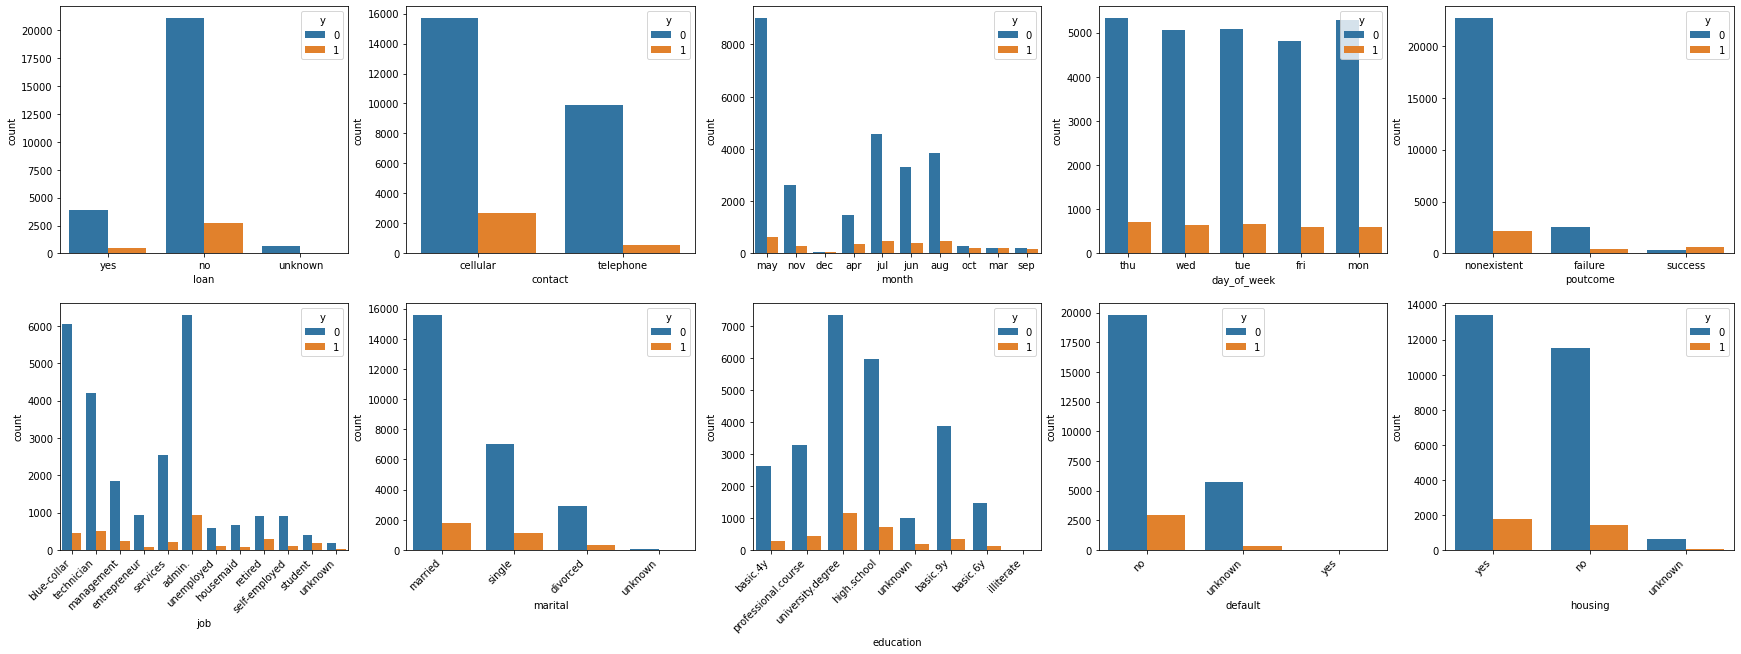

In [23]:
fig, ax = plt.subplots(2, 5, figsize=(30,10))
for i, category in enumerate(categorical_columns):
    if i > 4:
        sns.countplot(x=category, hue="y", data=eda_cat, ax=ax[0, i-5])
    else:
        sns.countplot(x=category, hue="y", data=eda_cat, ax=ax[1, i])
        ax[1, i].set_xticklabels(ax[1, i].get_xticklabels(), rotation=45, ha="right")

#### Numerical Data

In [24]:
eda_num = X_train[numerical_columns]
eda_num["y"] = deepcopy(y_train)

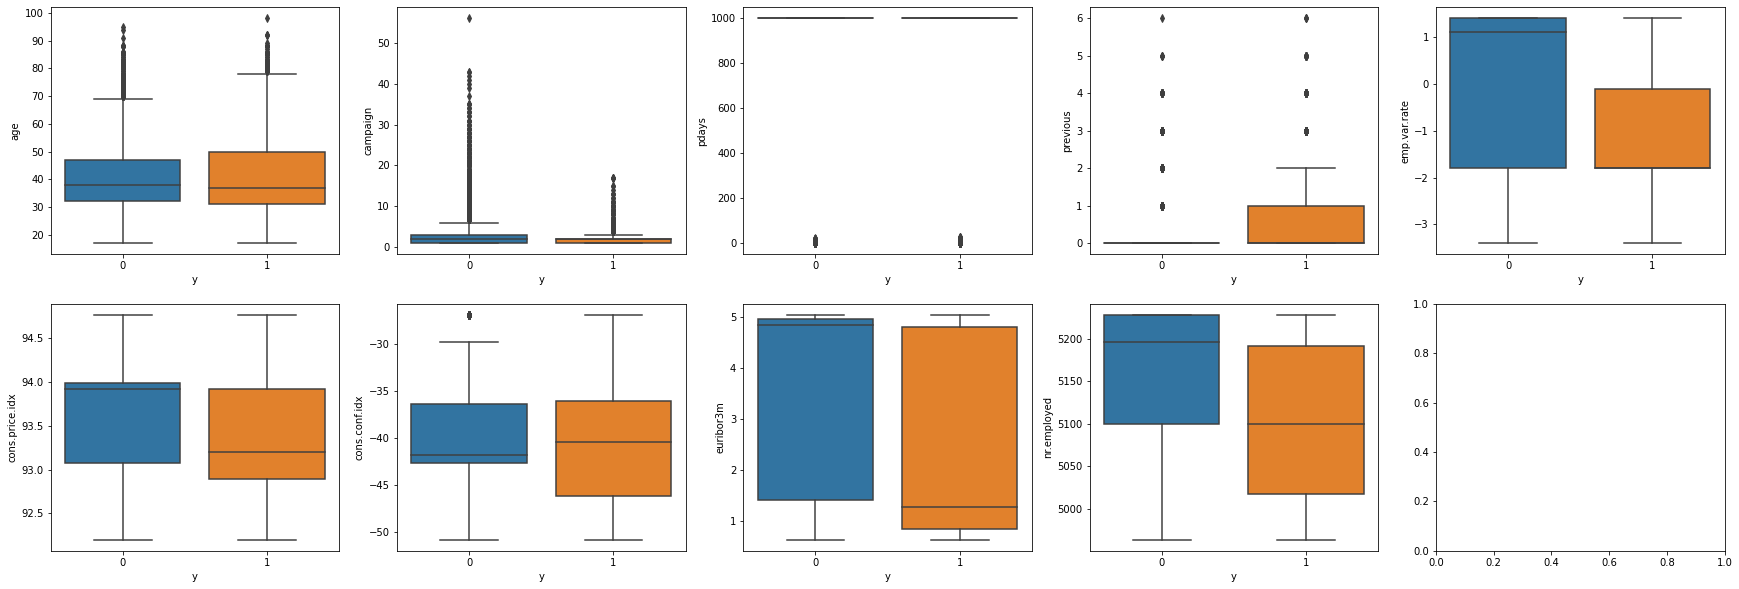

In [25]:
fig, ax = plt.subplots(2, 5, figsize=(30,10))
for i, category in enumerate(numerical_columns):
    if i < 5:
        sns.boxplot(y=category, x="y", data=eda_num, ax=ax[0, i])
    else:
        sns.boxplot(y=category, x="y", data=eda_num, ax=ax[1, i-5])

## **Data Preprocessing - Train Data**

### **Numerical Data Preprocessing**

In [26]:
# handling numerical data
X_train_num, num_imputer = numericalImputer(data=X_train,
                                            numerical_columns=numerical_columns)

In [27]:
X_train_num.shape

(28823, 9)

### **Categorical Data Preprocessing**

In [28]:
X_train_cat, cat_imputer, ohe_encoder, encoder_col = categoricalImputer(
    data=X_train, categorical_columns=categorical_columns
)

In [29]:
X_train_cat.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
31748,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
26671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
39007,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
30262,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
16695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [30]:
X_train_cat.shape

(28823, 52)

In [31]:
X_train_concat = pd.concat(
    [X_train_num, X_train_cat], axis=1
)

In [32]:
X_train_concat.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
31748,35.0,1.0,999.0,0.0,-1.8,92.893,-46.2,1.327,5099.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
26671,29.0,1.0,999.0,0.0,-0.1,93.200,-42.0,4.076,5195.8,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
39007,56.0,1.0,999.0,0.0,-3.0,92.713,-33.0,0.715,5023.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
30262,56.0,1.0,999.0,0.0,-1.8,93.075,-47.1,1.365,5099.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
16695,23.0,3.0,999.0,0.0,1.4,93.918,-42.7,4.963,5228.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [33]:
X_train_concat.shape

(28823, 61)

In [34]:
X_train_concat.isnull().any().sum()

0

### **Balancing the Data**

As per first check of the output data, the data is imblanace. Hence, the data would be balanced with SMOTE

In [35]:
# Create SMOTE object
smt = SMOTE(sampling_strategy="minority", random_state=123)

# Fit Object
X_train_smote, y_train = smt.fit_resample(X_train_concat, y_train)

In [36]:
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: y, dtype: float64

In [37]:
X_train_smote.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,35.0,1.0,999.0,0.0,-1.8,92.893,-46.2,1.327,5099.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,29.0,1.0,999.0,0.0,-0.1,93.200,-42.0,4.076,5195.8,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,56.0,1.0,999.0,0.0,-3.0,92.713,-33.0,0.715,5023.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,56.0,1.0,999.0,0.0,-1.8,93.075,-47.1,1.365,5099.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,23.0,3.0,999.0,0.0,1.4,93.918,-42.7,4.963,5228.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### **Standardized Train Data & Create Scaler**

In [38]:
# Standardized Variable
X_train_clean, scaler = dataStandarization(X_train_smote)

In [39]:
X_train_clean.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,-0.456169,-0.564825,0.35206,-0.456115,-0.761418,-0.931326,-1.114455,-0.867207,-0.417078,-0.650489,...,-0.206866,-0.18827,-0.510232,-0.520285,2.036700,-0.54141,-0.533590,-0.368626,0.532442,-0.342503
1,-0.955343,-0.564825,0.35206,-0.456115,0.226641,-0.444508,-0.330286,0.587587,0.690720,-0.650489,...,-0.206866,-0.18827,-0.510232,-0.520285,2.036700,-0.54141,-0.533590,-0.368626,0.532442,-0.342503
2,1.290941,-0.564825,0.35206,-0.456115,-1.458871,-1.216757,1.350076,-1.191083,-1.283154,-0.650489,...,-0.206866,-0.18827,-0.510232,-0.520285,-0.557874,-0.54141,2.127858,-0.368626,0.532442,-0.342503
3,1.290941,-0.564825,0.35206,-0.456115,-0.761418,-0.642724,-1.282491,-0.847097,-0.417078,-0.650489,...,-0.206866,-0.18827,-0.510232,-0.520285,2.036700,-0.54141,-0.533590,-0.368626,0.532442,-0.342503
4,-1.454517,0.304605,0.35206,-0.456115,1.098457,0.694042,-0.460981,1.056995,1.060749,-0.650489,...,-0.206866,-0.18827,-0.510232,-0.520285,-0.557874,-0.54141,2.127858,-0.368626,0.532442,-0.342503


#### **Data Preprocessing - Test Data**

In [40]:
X_test_clean = testDataProcessing(data=X_test,
                                  numerical_columns=numerical_columns,
                                  categorical_columns=categorical_columns,
                                  encoder_columns=encoder_col,
                                  numerical_imputer=num_imputer,
                                  categorical_imputer=cat_imputer,
                                  encoder=ohe_encoder,
                                  scaler=scaler)

In [41]:
X_test_clean.shape

(12353, 61)

In [42]:
X_test_clean.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
36391,-0.705756,-0.564825,-2.846136,1.028634,-1.400750,-0.820325,-0.106238,-0.901606,-0.679421,1.734223,...,-0.206866,-0.18827,-0.510232,-0.520285,-0.557874,2.102343,-0.53359,-0.368626,-1.972116,2.969624
12612,-0.372973,1.174036,0.352060,-0.456115,1.098457,0.694042,-0.460981,1.055408,1.060749,-0.650489,...,-0.206866,-0.18827,-0.510232,2.168650,-0.557874,-0.541410,-0.53359,-0.368626,0.532442,-0.342503
5791,-0.622560,5.086472,0.352060,-0.456115,0.924094,0.814557,0.715273,1.000899,0.635731,-0.650489,...,-0.206866,-0.18827,-0.510232,2.168650,-0.557874,-0.541410,-0.53359,-0.368626,0.532442,-0.342503
36083,-0.955343,-0.564825,0.352060,-0.456115,-0.761418,-0.931326,-1.114455,-0.899489,-0.417078,-0.650489,...,-0.206866,-0.18827,-0.510232,-0.520285,-0.557874,2.102343,-0.53359,-0.368626,0.532442,-0.342503
21332,-0.040190,0.304605,0.352060,-0.456115,1.098457,-0.057591,0.771285,1.056995,1.060749,-0.650489,...,-0.206866,-0.18827,-0.510232,2.168650,-0.557874,-0.541410,-0.53359,-0.368626,0.532442,-0.342503


## **Cross Validation**

In [43]:
# This dictionary is use to store the best parameter for each model
# will be used when we train the data with the best hyperparam
cv_best_params = {}

### Decision Tree Classifier

In [44]:
dec_tree = DecisionTreeClassifier(criterion="gini",
                                  random_state=123)
dec_tree_hyperparam = {
    "max_depth": np.arange(5, 37),
}

In [45]:
dec_tree_cv = modelCrossValidation(classifier=dec_tree,
                                   hyper_param=dec_tree_hyperparam,
                                   input_data=X_train_clean,
                                   output_data=y_train)

In [46]:
dec_tree_cv.best_params_

{'max_depth': 20}

In [47]:
cv_best_params["decision tree"] = dec_tree_cv.best_params_

In [48]:
dec_tree_cv.fit(X_train_clean, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36])})

In [49]:
dec_tree_cv.score(X_train_clean, y_train)

0.9785541132311542

### K-Nearest Neighbors

In [50]:
knn = KNeighborsClassifier(metric="manhattan")
knn_hyparam = {
    "n_neighbors": np.arange(3, 17)
}

In [51]:
knn_cv = modelCrossValidation(classifier=knn,
                              hyper_param=knn_hyparam,
                              input_data=X_train_clean,
                              output_data=y_train)

In [52]:
knn_cv.best_params_

{'n_neighbors': 3}

In [53]:
cv_best_params["knn"] = knn_cv.best_params_

### Logistic Regression

In [54]:
log_reg = LogisticRegression(solver="liblinear",
                             random_state=123)

log_reg_hyparams = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-5, 5, 25)
}

In [55]:
log_reg_cv = modelCrossValidation(classifier=log_reg,
                                  hyper_param=log_reg_hyparams,
                                  input_data=X_train_clean,
                                  output_data=y_train)

In [56]:
log_reg_cv.best_params_

{'C': 0.05623413251903491, 'penalty': 'l1'}

In [57]:
cv_best_params["logistic reg"] = log_reg_cv.best_params_

### AdaBoost Classifier

In [58]:
ada_dtree = DecisionTreeClassifier(max_depth=2, random_state=123)

ada_boost = AdaBoostClassifier(base_estimator=ada_dtree,
                               random_state=123)

ada_boost_hyparams = {
    "n_estimators": [200, 300, 400, 500, 600, 700]
}

In [59]:
ada_boost_cv = modelCrossValidation(classifier=ada_boost,
                                    hyper_param=ada_boost_hyparams,
                                    input_data=X_train_clean,
                                    output_data=y_train)

In [60]:
ada_boost_cv.best_params_

{'n_estimators': 700}

In [61]:
cv_best_params["adaboost"] = ada_boost_cv.best_params_

### Gradient Boost Classifier

In [62]:
gboost = GradientBoostingClassifier(random_state=123)

gboost_hyparams = {
    "n_estimators": [200, 300, 400, 500, 600, 700]
}

In [63]:
gboost_cv = modelCrossValidation(classifier=gboost,
                                 hyper_param=gboost_hyparams,
                                 input_data=X_train_clean,
                                 output_data=y_train)

In [64]:
gboost_cv.best_params_

{'n_estimators': 600}

In [65]:
cv_best_params["gradient boost"] = gboost_cv.best_params_

### Random Forest Classifier

In [66]:
random_forest = RandomForestClassifier(criterion="gini",
                                       max_features="sqrt",
                                       random_state=123)

random_forest_hyparams = {
    "n_estimators": [200, 300, 400, 500, 600, 700]
}

In [67]:
random_forest_cv = modelCrossValidation(classifier=random_forest,
                                        hyper_param=random_forest_hyparams,
                                        input_data=X_train_clean,
                                        output_data=y_train)

In [68]:
random_forest_cv.best_params_

{'n_estimators': 500}

In [69]:
cv_best_params["random forest"] = random_forest_cv.best_params_

### **Training ML Model with train data and CV Best Hyperparameter**

#### Train - Decision Tree

In [71]:
dtree_train = DecisionTreeClassifier(max_depth=cv_best_params["decision tree"]["max_depth"],
                                     random_state=123)

In [72]:
dtree_train.fit(X_train_clean, y_train)

DecisionTreeClassifier(max_depth=20, random_state=123)

##### Predict and Evaluate Train Data - Decision Tree

In [73]:
dtree_train_pred = modelPredictionResult(classifier=dtree_train,
                                         input_data=X_train_clean,
                                         output_data=y_train)

Confision Matrix
[True Negative: 25311    False Negative: 265]
[False Positive: 832   True Positive: 24744]


Classification Report
              precision    recall  f1-score   support

          no       0.97      0.99      0.98     25576
         yes       0.99      0.97      0.98     25576

    accuracy                           0.98     51152
   macro avg       0.98      0.98      0.98     51152
weighted avg       0.98      0.98      0.98     51152



In [74]:
dtree_train_scores = classScore(model_prediction=dtree_train_pred,
                                output_data=y_train)

Classification Score Summary
Classifier Accuracy score:  0.9785541132311542
Classifier Recall score:  0.9674695026587425
Classifier f1-score:  0.9783137293664129
Classifier precision:  0.9894038146267343


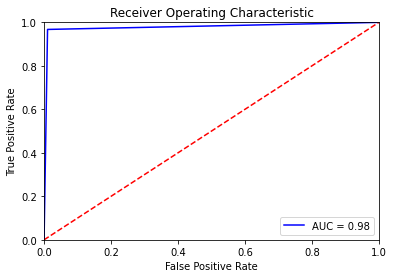

In [75]:
dtree_train_auroc = rocAucResult(model_prediction=dtree_train_pred,
                                 output_data=y_train)

#### Train - KNN Model

In [76]:
knn_train = KNeighborsClassifier(n_neighbors=cv_best_params["knn"]["n_neighbors"])

In [77]:
knn_train.fit(X_train_clean, y_train)

KNeighborsClassifier(n_neighbors=3)

##### Predict and Evaluate Train Data - KNN

In [78]:
knn_train_pred = modelPredictionResult(classifier=knn_train,
                                       input_data=X_train_clean,
                                       output_data=y_train)

Confision Matrix
[True Negative: 23386    False Negative: 2190]
[False Positive: 226   True Positive: 25350]


Classification Report
              precision    recall  f1-score   support

          no       0.99      0.91      0.95     25576
         yes       0.92      0.99      0.95     25576

    accuracy                           0.95     51152
   macro avg       0.96      0.95      0.95     51152
weighted avg       0.96      0.95      0.95     51152



In [79]:
knn_train_score = classScore(model_prediction=knn_train_pred,
                             output_data=y_train)

Classification Score Summary
Classifier Accuracy score:  0.9527682202064436
Classifier Recall score:  0.9911635908664372
Classifier f1-score:  0.9545146471872882
Classifier precision:  0.920479302832244


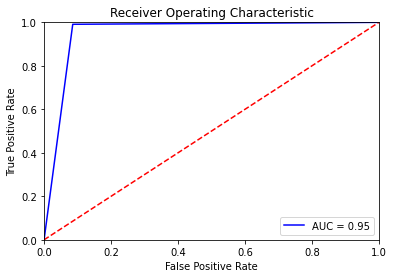

In [80]:
knn_train_auroc = rocAucResult(model_prediction=knn_train_pred,
                               output_data=y_train)

#### Train - Logistic Regression

In [81]:
log_reg_train = LogisticRegression(penalty=cv_best_params["logistic reg"]["penalty"],
                                   C=cv_best_params["logistic reg"]["C"],
                                   solver="liblinear",
                                   random_state=123)

In [82]:
log_reg_train.fit(X_train_clean, y_train)

LogisticRegression(C=0.05623413251903491, penalty='l1', random_state=123,
                   solver='liblinear')

In [83]:
log_reg_train_proba = log_reg_train.predict_proba(X_train_clean)

In [84]:
log_reg_train_pred = modelPredictionResult(classifier=log_reg_train,
                                           input_data=X_train_clean,
                                           output_data=y_train)

Confision Matrix
[True Negative: 21608    False Negative: 3968]
[False Positive: 9259   True Positive: 16317]


Classification Report
              precision    recall  f1-score   support

          no       0.70      0.84      0.77     25576
         yes       0.80      0.64      0.71     25576

    accuracy                           0.74     51152
   macro avg       0.75      0.74      0.74     51152
weighted avg       0.75      0.74      0.74     51152



##### Predict and Evaluate Train Data - Logistic Regression

In [85]:
log_reg_train_score = classScore(model_prediction=log_reg_train_pred,
                                 output_data=y_train)

Classification Score Summary
Classifier Accuracy score:  0.7414177353769159
Classifier Recall score:  0.6379809196121364
Classifier f1-score:  0.7115850068685812
Classifier precision:  0.8043874784323392


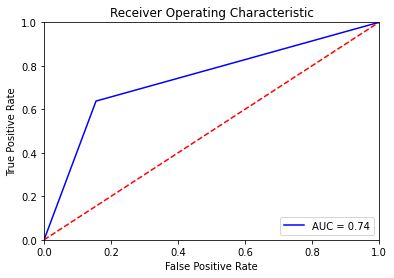

In [86]:
log_reg_train_aucroc = rocAucResult(model_prediction=log_reg_train_pred,
                                    output_data=y_train)

#### Train - AdaBoost

In [87]:
ada_dtree_train = DecisionTreeClassifier(max_depth=2, random_state=123)
adaboost_train = AdaBoostClassifier(base_estimator=ada_dtree_train,
                                    n_estimators=cv_best_params["adaboost"]["n_estimators"],
                                    random_state=123)

In [88]:
adaboost_train.fit(X_train_clean, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=123),
                   n_estimators=700, random_state=123)

##### Predict and Evaluate Train Data - Adaboost

In [89]:
adaboost_train_pred = modelPredictionResult(classifier=adaboost_train,
                                            input_data=X_train_clean,
                                            output_data=y_train)

Confision Matrix
[True Negative: 25170    False Negative: 406]
[False Positive: 1957   True Positive: 23619]


Classification Report
              precision    recall  f1-score   support

          no       0.93      0.98      0.96     25576
         yes       0.98      0.92      0.95     25576

    accuracy                           0.95     51152
   macro avg       0.96      0.95      0.95     51152
weighted avg       0.96      0.95      0.95     51152



In [90]:
adaboost_train_pred = adaboost_train.predict(X_train_clean)

In [91]:
adaboost_train_score = classScore(model_prediction=adaboost_train_pred,
                                  output_data=y_train)

Classification Score Summary
Classifier Accuracy score:  0.9538043478260869
Classifier Recall score:  0.9234829527682202
Classifier f1-score:  0.9523598314550109
Classifier precision:  0.9831009365244537


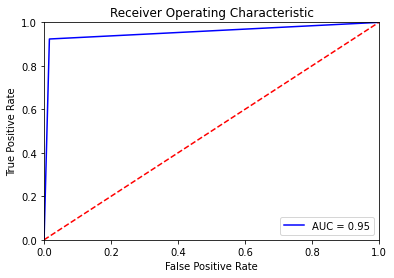

In [92]:
adaboost_train_aucroc = rocAucResult(model_prediction=adaboost_train_pred,
                                     output_data=y_train)

#### Train - Gradient Boosting

In [93]:
gboost_train = GradientBoostingClassifier(
    n_estimators=cv_best_params["gradient boost"]["n_estimators"],
    random_state=123
)

In [94]:
gboost_train.fit(X_train_clean, y_train)

GradientBoostingClassifier(n_estimators=600, random_state=123)

##### Predict and Evaluate Train Data - Gradient Boosting

In [95]:
gboost_train_pred = modelPredictionResult(classifier=gboost_train,
                                          input_data=X_train_clean,
                                          output_data=y_train)

Confision Matrix
[True Negative: 25152    False Negative: 424]
[False Positive: 2151   True Positive: 23425]


Classification Report
              precision    recall  f1-score   support

          no       0.92      0.98      0.95     25576
         yes       0.98      0.92      0.95     25576

    accuracy                           0.95     51152
   macro avg       0.95      0.95      0.95     51152
weighted avg       0.95      0.95      0.95     51152



In [96]:
gboost_train_score = classScore(model_prediction=gboost_train_pred,
                                output_data=y_train)

Classification Score Summary
Classifier Accuracy score:  0.9496598373475132
Classifier Recall score:  0.9158977166093213
Classifier f1-score:  0.9479008598887203
Classifier precision:  0.9822214767914798


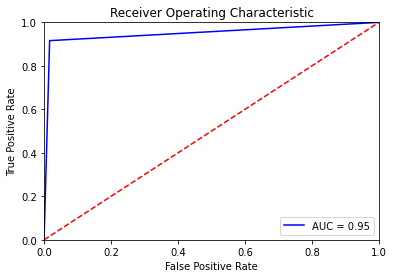

In [97]:
gboost_train_aucroc = rocAucResult(model_prediction=gboost_train_pred,
                                   output_data=y_train)

#### Train - Random Forest

In [98]:
r_forest_train = RandomForestClassifier(
    criterion="entropy",
    n_estimators=cv_best_params["random forest"]["n_estimators"],
    max_features="sqrt",
    random_state=123
)

In [99]:
r_forest_train.fit(X_train_clean, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=123)

##### Predict and Evaluate Train Data - Random Forest

In [100]:
r_forest_train_pred = modelPredictionResult(classifier=r_forest_train,
                                            input_data=X_train_clean,
                                            output_data=y_train)

Confision Matrix
[True Negative: 25548    False Negative: 28]
[False Positive: 99   True Positive: 25477]


Classification Report
              precision    recall  f1-score   support

          no       1.00      1.00      1.00     25576
         yes       1.00      1.00      1.00     25576

    accuracy                           1.00     51152
   macro avg       1.00      1.00      1.00     51152
weighted avg       1.00      1.00      1.00     51152



In [101]:
r_forest_train_score = classScore(model_prediction=r_forest_train_pred,
                                  output_data=y_train)

Classification Score Summary
Classifier Accuracy score:  0.9975172036284016
Classifier Recall score:  0.996129183609634
Classifier f1-score:  0.9975137526673322
Classifier precision:  0.998902176043913


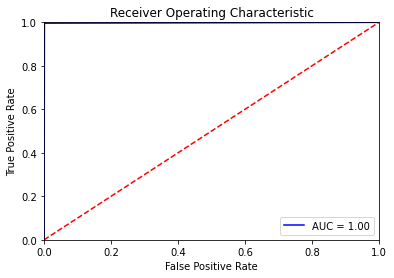

In [102]:
r_forest_train_aucroc = rocAucResult(model_prediction=r_forest_train_pred,
                                     output_data=y_train)

### Train Data Simple Report

In [103]:
train_score = {
    "Decision Tree": dtree_train_scores,
    "KNN": knn_train_score,
    "Logistic Regression": log_reg_train_score,
    "Random Forest": r_forest_train_score,
    "Adaboost": adaboost_train_score,
    "Gradient Boost": gboost_train_score,
}

In [104]:
train_score_df = pd.DataFrame(train_score)
train_score_df

,Decision Tree,KNN,Logistic Regression,Random Forest,Adaboost,Gradient Boost
accuracy,0.978554,0.952768,0.741418,0.997517,0.953804,0.949660
recall,0.967470,0.991164,0.637981,0.996129,0.923483,0.915898
f1_score,0.978314,0.954515,0.711585,0.997514,0.952360,0.947901
precision,0.989404,0.920479,0.804387,0.998902,0.983101,0.982221


In [105]:
auc_roc_data = {
    "Decision Tree": dtree_train_auroc,
    "KNN": knn_train_auroc,
    "Logistic Regression": log_reg_train_aucroc,
    "Random Forest": r_forest_train_aucroc,
    "Adaboost": adaboost_train_aucroc,
    "Gradient Boost": gboost_train_aucroc,
}

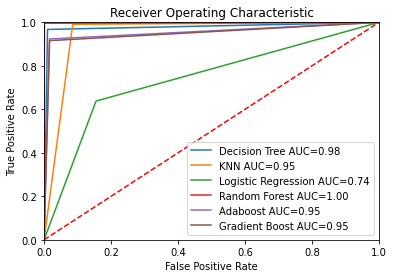

In [106]:
plt.title('Receiver Operating Characteristic')

for key in auc_roc_data.keys():
    fpr = auc_roc_data[key]["fpr"]
    tpr = auc_roc_data[key]["tpr"]
    roc_auc = auc_roc_data[key]["roc_auc"]

    plt.plot(fpr, tpr, label="%s AUC=%0.2f" % (key, roc_auc))

# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Test Model

#### Test - Decision Tree

In [107]:
dtree_test_pred = modelPredictionResult(classifier=dtree_train,
                                        input_data=X_test_clean,
                                        output_data=y_test)

Confision Matrix
[True Negative: 10138    False Negative: 823]
[False Positive: 909   True Positive: 483]


Classification Report
              precision    recall  f1-score   support

          no       0.92      0.92      0.92     10961
         yes       0.37      0.35      0.36      1392

    accuracy                           0.86     12353
   macro avg       0.64      0.64      0.64     12353
weighted avg       0.86      0.86      0.86     12353



In [108]:
dtree_test_score = classScore(model_prediction=dtree_test_pred,
                              output_data=y_test)

Classification Score Summary
Classifier Accuracy score:  0.859791143851696
Classifier Recall score:  0.34698275862068967
Classifier f1-score:  0.3580429948109711
Classifier precision:  0.36983154670750384


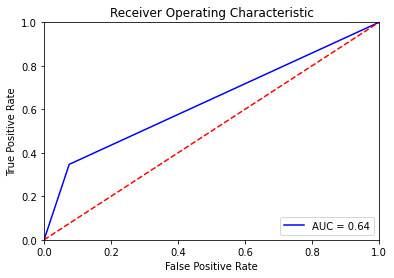

In [109]:
dtree_test_aucroc = rocAucResult(model_prediction=dtree_test_pred,
                                 output_data=y_test)

#### Test - KNN

In [110]:
knn_test_pred = modelPredictionResult(classifier=knn_train,
                                      input_data=X_test_clean,
                                      output_data=y_test)

Confision Matrix
[True Negative: 9309    False Negative: 1652]
[False Positive: 702   True Positive: 690]


Classification Report
              precision    recall  f1-score   support

          no       0.93      0.85      0.89     10961
         yes       0.29      0.50      0.37      1392

    accuracy                           0.81     12353
   macro avg       0.61      0.67      0.63     12353
weighted avg       0.86      0.81      0.83     12353



In [111]:
knn_test_score = classScore(model_prediction=knn_test_pred,
                            output_data=y_test)

Classification Score Summary
Classifier Accuracy score:  0.8094390026714159
Classifier Recall score:  0.4956896551724138
Classifier f1-score:  0.36957686127477235
Classifier precision:  0.2946199829205807


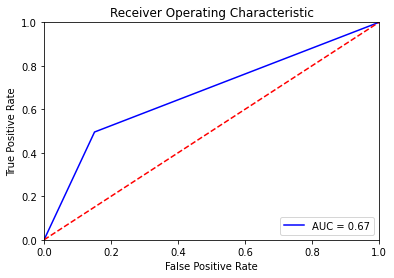

In [112]:
knn_test_aucroc = rocAucResult(model_prediction=knn_test_pred,
                               output_data=y_test)

### Test - Logistic Regression

In [113]:
logreg_test_pred = modelPredictionResult(classifier=log_reg_train,
                                         input_data=X_test_clean,
                                         output_data=y_test)

Confision Matrix
[True Negative: 9302    False Negative: 1659]
[False Positive: 492   True Positive: 900]


Classification Report
              precision    recall  f1-score   support

          no       0.95      0.85      0.90     10961
         yes       0.35      0.65      0.46      1392

    accuracy                           0.83     12353
   macro avg       0.65      0.75      0.68     12353
weighted avg       0.88      0.83      0.85     12353



In [114]:
logreg_test_score = classScore(model_prediction=logreg_test_pred,
                               output_data=y_test)

Classification Score Summary
Classifier Accuracy score:  0.8258722577511536
Classifier Recall score:  0.646551724137931
Classifier f1-score:  0.45558086560364464
Classifier precision:  0.3516998827667057


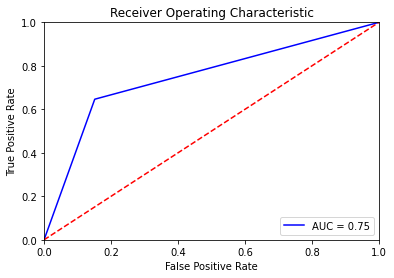

In [115]:
logreg_test_aucroc = rocAucResult(model_prediction=logreg_test_pred,
                                  output_data=y_test)

### Test - AdaBoost

In [116]:
adaboost_test_pred = modelPredictionResult(classifier=adaboost_train,
                                           input_data=X_test_clean,
                                           output_data=y_test)

Confision Matrix
[True Negative: 10643    False Negative: 318]
[False Positive: 994   True Positive: 398]


Classification Report
              precision    recall  f1-score   support

          no       0.91      0.97      0.94     10961
         yes       0.56      0.29      0.38      1392

    accuracy                           0.89     12353
   macro avg       0.74      0.63      0.66     12353
weighted avg       0.87      0.89      0.88     12353



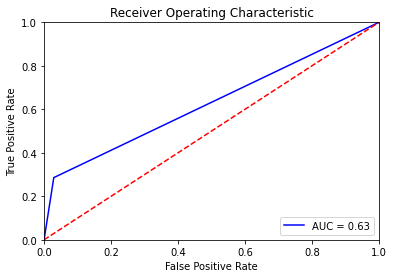

In [117]:
adaboost_test_aucroc = rocAucResult(model_prediction=adaboost_test_pred,
                                    output_data=y_test)

In [118]:
adaboost_test_score = classScore(model_prediction=adaboost_test_pred,
                                 output_data=y_test)

Classification Score Summary
Classifier Accuracy score:  0.893790981947705
Classifier Recall score:  0.2859195402298851
Classifier f1-score:  0.37760910815939286
Classifier precision:  0.5558659217877095


### Test - GradientBoost

In [119]:
gboost_test_pred = modelPredictionResult(classifier=gboost_train,
                                         input_data=X_test_clean,
                                         output_data=y_test)

Confision Matrix
[True Negative: 10689    False Negative: 272]
[False Positive: 992   True Positive: 400]


Classification Report
              precision    recall  f1-score   support

          no       0.92      0.98      0.94     10961
         yes       0.60      0.29      0.39      1392

    accuracy                           0.90     12353
   macro avg       0.76      0.63      0.67     12353
weighted avg       0.88      0.90      0.88     12353



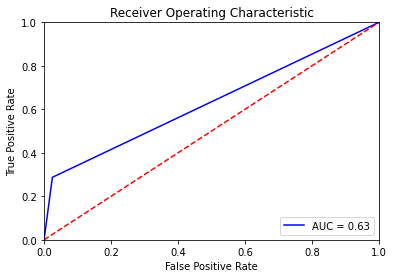

In [120]:
gboost_test_aucroc = rocAucResult(model_prediction=gboost_test_pred,
                                  output_data=y_test)

In [121]:
gboost_test_score = classScore(model_prediction=gboost_test_pred,
                                output_data=y_test)

Classification Score Summary
Classifier Accuracy score:  0.8976766777301061
Classifier Recall score:  0.28735632183908044
Classifier f1-score:  0.38759689922480617
Classifier precision:  0.5952380952380952


#### Test - Random Forest

In [122]:
rdforest_test_pred = modelPredictionResult(classifier=r_forest_train,
                                           input_data=X_test_clean,
                                           output_data=y_test)

Confision Matrix
[True Negative: 10600    False Negative: 361]
[False Positive: 963   True Positive: 429]


Classification Report
              precision    recall  f1-score   support

          no       0.92      0.97      0.94     10961
         yes       0.54      0.31      0.39      1392

    accuracy                           0.89     12353
   macro avg       0.73      0.64      0.67     12353
weighted avg       0.87      0.89      0.88     12353



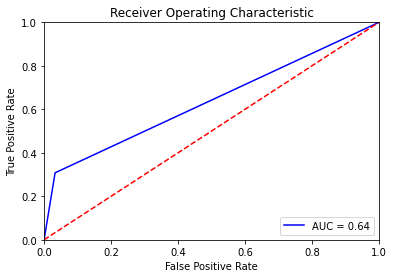

In [123]:
rdforest_test_aucroc = rocAucResult(model_prediction=rdforest_test_pred,
                                    output_data=y_test)

In [124]:
rforest_test_score = classScore(model_prediction=rdforest_test_pred,
                                output_data=y_test)

Classification Score Summary
Classifier Accuracy score:  0.8928195580021048
Classifier Recall score:  0.3081896551724138
Classifier f1-score:  0.3932172318973419
Classifier precision:  0.5430379746835443


### Simple Test Report

In [125]:
test_scores = {
    "Decision Tree": dtree_test_score,
    "KNN": knn_test_score,
    "Logistic Regression": logreg_test_score,
    "Random Forest": rforest_test_score,
    "Adaboost": adaboost_test_score,
    "Gradient Boost": gboost_test_score,
}

In [126]:
test_scores_df = pd.DataFrame(test_scores)
test_scores_df

,Decision Tree,KNN,Logistic Regression,Random Forest,Adaboost,Gradient Boost
accuracy,0.859791,0.809439,0.825872,0.892820,0.893791,0.897677
recall,0.346983,0.495690,0.646552,0.308190,0.285920,0.287356
f1_score,0.358043,0.369577,0.455581,0.393217,0.377609,0.387597
precision,0.369832,0.294620,0.351700,0.543038,0.555866,0.595238


In [127]:
test_aucroc = {
    "Decision Tree": dtree_test_aucroc,
    "KNN": knn_test_aucroc,
    "Logistic Regression": logreg_test_aucroc,
    "Random Forest": rdforest_test_aucroc,
    "Adaboost": adaboost_test_aucroc,
    "Gradient Boost": gboost_test_aucroc,
}

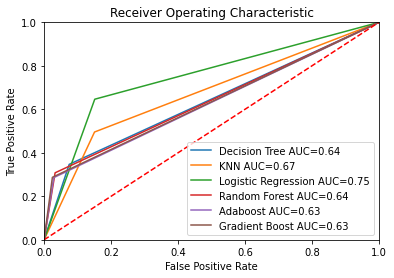

In [128]:
plt.title('Receiver Operating Characteristic')

for key in test_aucroc.keys():
    fpr = test_aucroc[key]["fpr"]
    tpr = test_aucroc[key]["tpr"]
    roc_auc = test_aucroc[key]["roc_auc"]

    plt.plot(fpr, tpr, label="%s AUC=%0.2f" % (key, roc_auc))

# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Experimenting with AdaBoost

In [208]:
adaboost_exp_result = {}

In [238]:
exp = "exp3"
adaboost_exp_result[exp] = {}

In [239]:
adaboost_hyparams_exp = {
    "n_estimators": 100,
    "learning_rate": 0.001
}

In [240]:
adaboost_exp_result[exp]["hyperparam"] = adaboost_hyparams_exp

In [241]:
adaboost_exp_result

{'exp1': {'hyperparam': {'n_estimators': 700, 'learning_rate': 0.1},
  'train': {'score': {'accuracy': 0.9495034407256803,
    'recall': 0.9144510478573663,
    'f1_score': 0.9476691180939647,
    'precision': 0.9833914981289156},
   'aucroc': {'fpr': array([0.        , 0.01544417, 1.        ]),
    'tpr': array([0.        , 0.91445105, 1.        ]),
    'roc_auc': 0.9495034407256803}},
  'test': {'score': {'accuracy': 0.8978385817210395,
    'recall': 0.27370689655172414,
    'f1_score': 0.3764822134387352,
    'precision': 0.6028481012658228},
   'aucroc': {'fpr': array([0.        , 0.02289937, 1.        ]),
    'tpr': array([0.       , 0.2737069, 1.       ]),
    'roc_auc': 0.6254037630281657}}},
 'exp2': {'hyperparam': {'n_estimators': 1000, 'learning_rate': 0.01},
  'train': {'score': {'accuracy': 0.9495034407256803,
    'recall': 0.9144510478573663,
    'f1_score': 0.9476691180939647,
    'precision': 0.9833914981289156},
   'aucroc': {'fpr': array([0.        , 0.01544417, 1.    

In [242]:
ada_tree_exp = DecisionTreeClassifier(max_depth=2, random_state=123)
adaboost_exp = AdaBoostClassifier(
    base_estimator=ada_tree_exp,
    n_estimators=adaboost_hyparams_exp["n_estimators"],
    learning_rate=adaboost_hyparams_exp["learning_rate"],
    random_state=123)

In [243]:
adaboost_exp1.fit(X_train_clean, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=123),
                   learning_rate=0.1, n_estimators=2000, random_state=123)

In [244]:
adaboost_train_exp_pred = modelPredictionResult(
    classifier=adaboost_exp1,
    input_data=X_train_clean,
    output_data=y_train
)

Confision Matrix
[True Negative: 25181    False Negative: 395]
[False Positive: 2188   True Positive: 23388]


Classification Report
              precision    recall  f1-score   support

          no       0.92      0.98      0.95     25576
         yes       0.98      0.91      0.95     25576

    accuracy                           0.95     51152
   macro avg       0.95      0.95      0.95     51152
weighted avg       0.95      0.95      0.95     51152



In [245]:
adaboost_train_exp_score = classScore(
    model_prediction=adaboost_train_exp_pred,
    output_data=y_train
)

Classification Score Summary
Classifier Accuracy score:  0.9495034407256803
Classifier Recall score:  0.9144510478573663
Classifier f1-score:  0.9476691180939647
Classifier precision:  0.9833914981289156


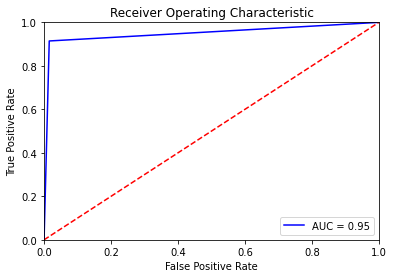

In [246]:
adaboost_train_exp1_aucroc = rocAucResult(
    model_prediction=adaboost_train_exp_pred,
    output_data=y_train
)

In [247]:
adaboost_exp_result[exp]["train"] = {
    "score": adaboost_train_exp_score,
    "aucroc": adaboost_train_exp1_aucroc,
}

In [248]:
adaboost_test_exp_pred = modelPredictionResult(
    classifier=adaboost_exp1,
    input_data=X_test_clean,
    output_data=y_test
)

Confision Matrix
[True Negative: 10710    False Negative: 251]
[False Positive: 1011   True Positive: 381]


Classification Report
              precision    recall  f1-score   support

          no       0.91      0.98      0.94     10961
         yes       0.60      0.27      0.38      1392

    accuracy                           0.90     12353
   macro avg       0.76      0.63      0.66     12353
weighted avg       0.88      0.90      0.88     12353



In [249]:
adaboost_test_exp_score = classScore(
    model_prediction=adaboost_test_exp_pred,
    output_data=y_test
)

Classification Score Summary
Classifier Accuracy score:  0.8978385817210395
Classifier Recall score:  0.27370689655172414
Classifier f1-score:  0.3764822134387352
Classifier precision:  0.6028481012658228


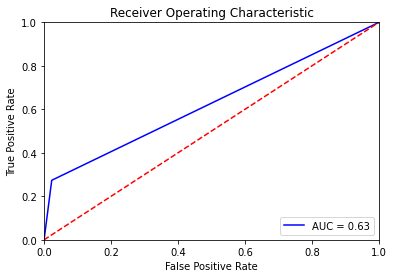

In [250]:
adaboost_test_exp_aucroc = rocAucResult(
    model_prediction=adaboost_test_exp_pred,
    output_data=y_test,
)

In [251]:
adaboost_exp_result[exp]["test"] = {
    "score": adaboost_test_exp_score,
    "aucroc": adaboost_test_exp_aucroc,
}

In [453]:
adaboost_exp_result

{'exp1': {'hyperparam': {'n_estimators': 700, 'learning_rate': 0.1},
  'train': {'score': {'accuracy': 0.9495034407256803,
    'recall': 0.9144510478573663,
    'f1_score': 0.9476691180939647,
    'precision': 0.9833914981289156},
   'aucroc': {'fpr': array([0.        , 0.01544417, 1.        ]),
    'tpr': array([0.        , 0.91445105, 1.        ]),
    'roc_auc': 0.9495034407256803}},
  'test': {'score': {'accuracy': 0.8978385817210395,
    'recall': 0.27370689655172414,
    'f1_score': 0.3764822134387352,
    'precision': 0.6028481012658228},
   'aucroc': {'fpr': array([0.        , 0.02289937, 1.        ]),
    'tpr': array([0.       , 0.2737069, 1.       ]),
    'roc_auc': 0.6254037630281657}}},
 'exp2': {'hyperparam': {'n_estimators': 1000, 'learning_rate': 0.01},
  'train': {'score': {'accuracy': 0.9495034407256803,
    'recall': 0.9144510478573663,
    'f1_score': 0.9476691180939647,
    'precision': 0.9833914981289156},
   'aucroc': {'fpr': array([0.        , 0.01544417, 1.    

### Experimenting with Gradient Boost

In [252]:
gboost_exp_result = {}

In [322]:
exp = "exp5"
gboost_exp_result[exp] = {}

In [336]:
gboost_exp_hyperparam = {
    "n_estimators": 100,
    "learning_rate": 0.01,
}

In [337]:
gboost_exp_result[exp]["hyperparams"] = gboost_exp_hyperparam

In [338]:
gboost_exp_train = GradientBoostingClassifier(
    n_estimators=gboost_exp_hyperparam["n_estimators"],
    learning_rate=gboost_exp_hyperparam["learning_rate"],
    random_state=123
)

In [339]:
gboost_exp_train.fit(X_train_clean, y_train)

GradientBoostingClassifier(learning_rate=0.01, random_state=123)

In [340]:
gboost_exp_train_pred = modelPredictionResult(
    classifier=gboost_exp_train,
    input_data=X_train_clean,
    output_data=y_train
)

Confision Matrix
[True Negative: 22784    False Negative: 2792]
[False Positive: 7968   True Positive: 17608]


Classification Report
              precision    recall  f1-score   support

          no       0.74      0.89      0.81     25576
         yes       0.86      0.69      0.77     25576

    accuracy                           0.79     51152
   macro avg       0.80      0.79      0.79     51152
weighted avg       0.80      0.79      0.79     51152



In [341]:
gboost_exp_train_score = classScore(
    model_prediction=gboost_exp_train_pred,
    output_data=y_train
)

Classification Score Summary
Classifier Accuracy score:  0.7896465436346575
Classifier Recall score:  0.688457929308727
Classifier f1-score:  0.765964851226727
Classifier precision:  0.8631372549019608


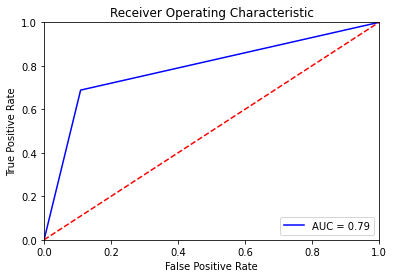

In [342]:
gboost_exp_train_aucroc = rocAucResult(
    model_prediction=gboost_exp_train_pred,
    output_data=y_train
)

In [343]:
gboost_exp_result[exp]["train"] = {
    "score": gboost_exp_train_score,
    "aucroc": gboost_exp_train_aucroc,
}

#### Gboost Experiment - Test and Predict

In [344]:
gboost_exp_test_pred = modelPredictionResult(
    classifier=gboost_exp_train,
    input_data=X_test_clean,
    output_data=y_test
)

Confision Matrix
[True Negative: 9795    False Negative: 1166]
[False Positive: 581   True Positive: 811]


Classification Report
              precision    recall  f1-score   support

          no       0.94      0.89      0.92     10961
         yes       0.41      0.58      0.48      1392

    accuracy                           0.86     12353
   macro avg       0.68      0.74      0.70     12353
weighted avg       0.88      0.86      0.87     12353



In [345]:
gboost_exp_test_score = classScore(
    model_prediction=gboost_exp_test_pred,
    output_data=y_test
)

Classification Score Summary
Classifier Accuracy score:  0.8585768639196956
Classifier Recall score:  0.5826149425287356
Classifier f1-score:  0.4814485010388839
Classifier precision:  0.41021750126454226


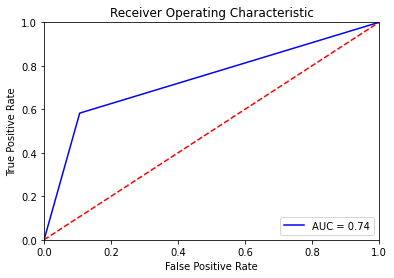

In [346]:
gboost_exp_test_aucroc = rocAucResult(
    model_prediction=gboost_exp_test_pred,
    output_data=y_test
)

In [347]:
gboost_exp_result[exp]["test"] = {
    "score": gboost_exp_test_score,
    "aucroc": gboost_exp_test_aucroc,
}

In [454]:
gboost_exp_result

{'exp1': {'hyperparams': {'n_estimators': 600, 'learning_rate': 0.1},
  'train': {'score': {'accuracy': 0.9496598373475132,
    'recall': 0.9158977166093213,
    'f1_score': 0.9479008598887203,
    'precision': 0.9822214767914798},
   'aucroc': {'fpr': array([0.        , 0.01657804, 1.        ]),
    'tpr': array([0.        , 0.91589772, 1.        ]),
    'roc_auc': 0.9496598373475134}},
  'test': {'score': {'accuracy': 0.8976766777301061,
    'recall': 0.28735632183908044,
    'f1_score': 0.38759689922480617,
    'precision': 0.5952380952380952},
   'aucroc': {'fpr': array([0.        , 0.02481525, 1.        ]),
    'tpr': array([0.        , 0.28735632, 1.        ]),
    'roc_auc': 0.6312705338782119}}},
 'exp2': {'hyperparams': {'n_estimators': 1000, 'learning_rate': 0.01},
  'train': {'score': {'accuracy': 0.9317133249921802,
    'recall': 0.9006881451360651,
    'f1_score': 0.9295268838898416,
    'precision': 0.9602734586685564},
   'aucroc': {'fpr': array([0.       , 0.0372615, 1.

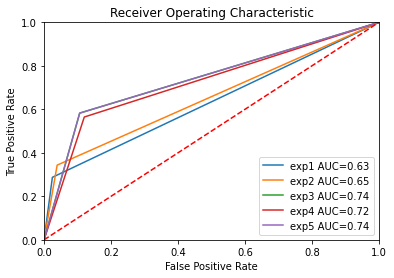

In [456]:
# ROC AUC Experiment Testing
plt.title('Receiver Operating Characteristic')

for key in gboost_exp_result:
    fpr = gboost_exp_result[key]["test"]["aucroc"]["fpr"]
    tpr = gboost_exp_result[key]["test"]["aucroc"]["tpr"]
    roc_auc = gboost_exp_result[key]["test"]["aucroc"]["roc_auc"]
    
    plt.plot(fpr, tpr, label="%s AUC=%0.2f" % (key, roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

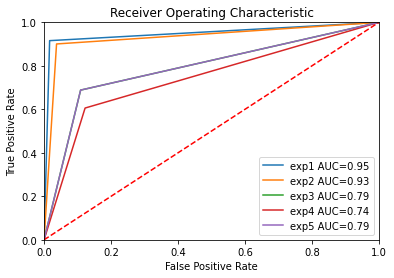

In [457]:
# ROC AUC Experiment Testing
plt.title('Receiver Operating Characteristic')

for key in gboost_exp_result:
    fpr = gboost_exp_result[key]["train"]["aucroc"]["fpr"]
    tpr = gboost_exp_result[key]["train"]["aucroc"]["tpr"]
    roc_auc = gboost_exp_result[key]["train"]["aucroc"]["roc_auc"]
    
    plt.plot(fpr, tpr, label="%s AUC=%0.2f" % (key, roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [472]:
for key in gboost_exp_result:
    print(gboost_exp_result[key]["hyperparams"])

{'n_estimators': 600, 'learning_rate': 0.1}
{'n_estimators': 1000, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 150, 'learning_rate': 0.001}
{'n_estimators': 100, 'learning_rate': 0.01}


### Experimenting with Random Forest

In [374]:
rforest_exp_result = {}

In [450]:
exp = "exp4"
rforest_exp_result[exp] = {}

In [427]:
rforest_exp_hyperparam = {
    "n_estimators": 50,
}

In [428]:
rforest_exp_result[exp]["hyperparams"] = rforest_exp_hyperparam

In [429]:
rforest_exp_train = RandomForestClassifier(
    criterion="gini",
    max_features="sqrt",
    n_estimators=rforest_exp_hyperparam["n_estimators"],
    random_state=123
)

In [430]:
rforest_exp_train.fit(X_train_clean, y_train)

RandomForestClassifier(n_estimators=50, random_state=123)

In [431]:
rforest_exp_train_pred = modelPredictionResult(
    classifier=rforest_exp_train,
    input_data=X_train_clean,
    output_data=y_train
)

Confision Matrix
[True Negative: 25536    False Negative: 40]
[False Positive: 106   True Positive: 25470]


Classification Report
              precision    recall  f1-score   support

          no       1.00      1.00      1.00     25576
         yes       1.00      1.00      1.00     25576

    accuracy                           1.00     51152
   macro avg       1.00      1.00      1.00     51152
weighted avg       1.00      1.00      1.00     51152



In [432]:
rforest_exp_train_score = classScore(
    model_prediction=rforest_exp_train_pred,
    output_data=y_train
)

Classification Score Summary
Classifier Accuracy score:  0.9971457616515483
Classifier Recall score:  0.9958554895214263
Classifier f1-score:  0.9971420741494735
Classifier precision:  0.9984319874558997


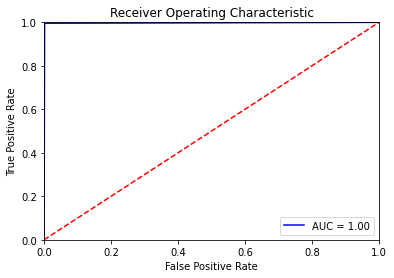

In [433]:
rforest_exp_train_aucroc = rocAucResult(
    model_prediction=rforest_exp_train_pred,
    output_data=y_train
)

In [434]:
rforest_exp_result[exp]["train"] = {
    "score": rforest_exp_train_score,
    "aucroc": rforest_exp_train_aucroc,
}

#### Random Forest Experiment - Test and Prediction

In [435]:
rforest_exp_test_pred = modelPredictionResult(
    classifier=rforest_exp_train,
    input_data=X_test_clean,
    output_data=y_test
)

Confision Matrix
[True Negative: 10590    False Negative: 371]
[False Positive: 961   True Positive: 431]


Classification Report
              precision    recall  f1-score   support

          no       0.92      0.97      0.94     10961
         yes       0.54      0.31      0.39      1392

    accuracy                           0.89     12353
   macro avg       0.73      0.64      0.67     12353
weighted avg       0.87      0.89      0.88     12353



In [436]:
rforest_exp_test_score = classScore(
    model_prediction=rforest_exp_test_pred,
    output_data=y_test
)

Classification Score Summary
Classifier Accuracy score:  0.8921719420383712
Classifier Recall score:  0.30962643678160917
Classifier f1-score:  0.39288969917958066
Classifier precision:  0.5374064837905237


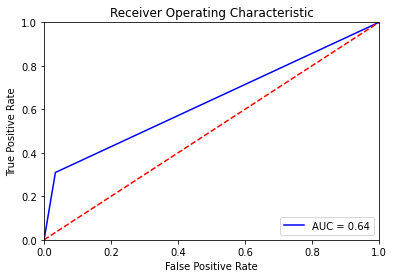

In [437]:
rforest_exp_test_aucroc = rocAucResult(
    model_prediction=rforest_exp_test_pred,
    output_data=y_test
)

In [438]:
rforest_exp_result[exp]["test"] = {
    "score": rforest_exp_test_score,
    "aucroc": rforest_exp_test_aucroc,
}